<a href="https://colab.research.google.com/github/Big-Shu-Nim/NLP/blob/main/C3_W3_Lab_1_single_layer_LSTM_0421_2%ED%9A%8C%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 공부로그
0415_
0421_
코세라_자연어_3주차학습
Scheduled: Apr 21, 2023 7:30 PM to 8:35 PM, GMT+9

코세라_자연어_3주차학습
Scheduled: Apr 21, 2023 8:40 PM to 9:40 PM, GMT+9

코세라_자연어_3주차학습
Scheduled: Apr 21, 2023 9:40 PM to 10:30 PM, GMT+9


<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_1_single_layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Single Layer LSTM

So far in this course, you've been using mostly basic dense layers and embeddings to build your models. It detects how the combination of words (or subwords) in the input text determines the output class. In the labs this week, you will look at other layers you can use to build your models. Most of these will deal with *Recurrent Neural Networks*, a kind of model that takes the ordering of inputs into account. This makes it suitable for different applications such as parts-of-speech tagging, music composition, language translation, and the like. For example, you may want your model to differentiate sentiments even if the words used in two sentences are the same:

```
1: My friends do like the movie but I don't. --> negative review
2: My friends don't like the movie but I do. --> positive review
```

The first layer you will be looking at is the [*LSTM (Long Short-Term Memory)*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In a nutshell, it computes the state of a current timestep and passes it on to the next timesteps where this state is also updated. The process repeats until the final timestep where the output computation is affected by all previous states. Not only that, it can be configured to be bidirectional so you can get the relationship of later words to earlier ones. If you want to go in-depth of how these processes work, you can look at the [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models) course of the Deep Learning Specialization. For this lab, you can take advantage of Tensorflow's APIs that implements the complexities of these layers for you. This makes it easy to just plug it in to your model. Let's see how to do that in the next sections below. 

## Download the dataset

For this lab, you will use the `subwords8k` pre-tokenized [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews). You will load it via Tensorflow Datasets as you've done last week:

In [2]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete468A7W/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete468A7W/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete468A7W/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


## Prepare the dataset

You can then get the train and test splits and generate padded batches. 

*Note: To make the training go faster in this lab, you will increase the batch size that Laurence used in the lecture. In particular, you will use `256` and this takes roughly a minute to train per epoch. In the video, Laurence used `16` which takes around 4 minutes per epoch.*

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256
# # batch size can make the training faster.

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

# why do we need to batch ?

When training neural networks, it is common to process multiple data samples at once in parallel. This approach, known as mini-batch gradient descent, is more computationally efficient than processing one sample at a time (i.e., stochastic gradient descent). A "batch" is a collection of samples that are processed simultaneously during training or evaluation.


## The reason why we need batching and padded here.

Suppose you have the following sequences of word indices:

sequence 1: [3, 10, 15]
sequence 2: [8, 4]
sequence 3: [1, 6, 7, 12]

These sequences have different lengths (3, 2, and 4). To create a batch, we can pad the sequences to the same length. In this case, the longest sequence has a length of 4, so we pad the shorter sequences to this length:

sequence 1 (padded): [3, 10, 15, 0]
sequence 2 (padded): [8, 4, 0, 0]
sequence 3 (padded): [1, 6, 7, 12]

Now, the padded sequences have the same length, and we can create a batch:

batch: [[3, 10, 15, 0],
[8, 4, 0, 0],
[1, 6, 7, 12]]


## Build and compile the model

Now you will build the model. You will simply swap the `Flatten` or `GlobalAveragePooling1D` from before with an `LSTM` layer. Moreover, you will nest it inside a [Biderectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) layer so the passing of the sequence information goes both forwards and backwards. These additional computations will naturally make the training go slower than the models you built last week. You should take this into account when using RNNs in your own applications.

In [4]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm_dim = 64
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


## Vocab size has nothing to do with parameters number

The fact that the input vocabulary has only 10,000 words does not necessarily mean that the number of trainable parameters will be small. The embedding layer can still have a large number of parameters because it needs to learn a unique vector representation for each word in the vocabulary. The total number of trainable parameters is determined by the architecture of the model and the size of each layer, not by the size of the input vocabulary.


In [1]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: ignored

## Train the model

Now you can start training. Using the default parameters above, you should reach around 98% training accuracy and 82% validation accuracy. You can visualize the results using the same plot utilities. See if you can still improve on this by modifying the hyperparameters or by training with more epochs.

In [6]:
NUM_EPOCHS = 10

history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 48s 376ms/step - loss: 0.6985 - accuracy: 0.5468 - val_loss: 0.6568 - val_accuracy: 0.6458
Epoch 2/10
98/98 [==============================] - 32s 323ms/step - loss: 0.4564 - accuracy: 0.7962 - val_loss: 0.5178 - val_accuracy: 0.7542
Epoch 3/10
98/98 [==============================] - 31s 317ms/step - loss: 0.3262 - accuracy: 0.8698 - val_loss: 0.3993 - val_accuracy: 0.8306
Epoch 4/10
98/98 [==============================] - 28s 285ms/step - loss: 0.2636 - accuracy: 0.9030 - val_loss: 0.5092 - val_accuracy: 0.7513
Epoch 5/10
98/98 [==============================] - 25s 249ms/step - loss: 0.2317 - accuracy: 0.9151 - val_loss: 0.4268 - val_accuracy: 0.8500
Epoch 6/10
98/98 [==============================] - 24s 246ms/step - loss: 0.1796 - accuracy: 0.9376 - val_loss: 0.4298 - val_accuracy: 0.8384
Epoch 7/10
98/98 [==============================] - 24s 243ms/step - loss: 0.1507 - accuracy: 0.9484 - val_loss: 0.6986 - val_accuracy: 0.6830

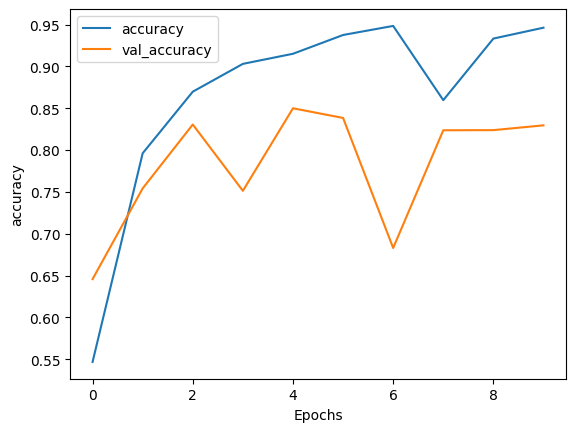

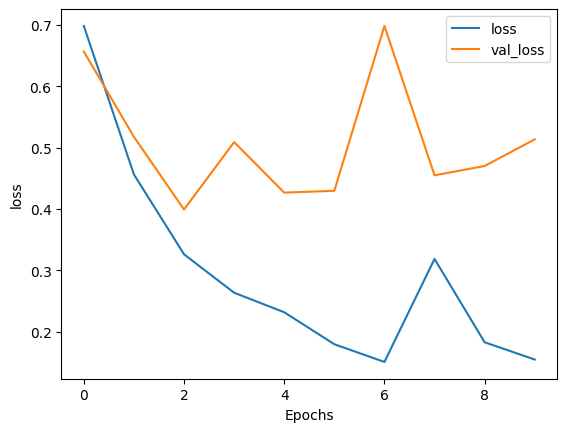

In [7]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

In this lab, you got a first look at using LSTM layers to build Recurrent Neural Networks. You only used a single LSTM layer but this can be stacked as well to build deeper networks. You will see how to do that in the next lab.